In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR
from torch.utils.data import DataLoader

from swag import SWAG
from models import SimpleNet, ConvNN, Classification_NN
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights
from data_gen import get_classification_data, ClassificationDataSet

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Classification on a toy dataset

Since the paper proposed that the SWAG algorithm will be able to closely approximate the posterior of neural networks, we would like to apply this idea to a simple task of OOD detection. 

In the below section, we will apply SWAG to a really simple dataset borrowed from HW7 for OOD detection. Specifically, we have strategically selected a number of points to evaluate the model's ability to capture aleatoric and epistemic uncertainties. The expected behavior for the test points are described as the follows:
- `(-1, -1.5), (1, 1.5)`: in-distribution samples, should be classified corrected with high certainty
- `(-5, -5), (5, 5)`: OOD samples, should be assigned high uncertainty in prediction
- `(-5, 3.5), (5, -3.5)`: OOD samples, should be assigned high uncertainty in prediction. Note that these two points are roughly right on top of the linear decision boundary that separates the two classes, which means correctly assigning uncertainties is more challenging
- `(-1, 1), (1, -0.2)`: in-distribution samples, selected to evaluate the model's ability to capture aleatoric uncertainties since they lie on top of the two classes

In [2]:
(X, y), X_test = get_classification_data()

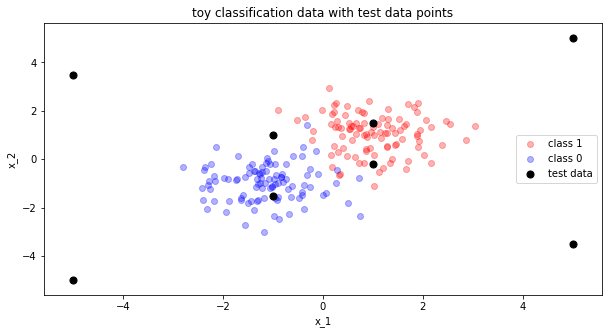

In [3]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

In [4]:
# Take a look at the architecture of Classification_NN
Classification_NN()

Classification_NN(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=2, bias=True)
)

In [5]:
# Initialize SWAG
swag = SWAG(Classification_NN, K = 5)
print("Total number of parameters for the NN is:", swag.weigt_D)

Total number of parameters for the NN is: 28


In [6]:
# Compile swag
objective = 'classification'
lr = 1e-3
momentum = 0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
train_scheduler = StepLR
swa_scheduler = LambdaLR

swag.compile(objective, lr, momentum, optimizer, loss_fn, train_scheduler, swa_scheduler)

In [7]:
# Initialize the training DataSet
train_data = ClassificationDataSet(n_samples=1000, mode='train')
train_gen = DataLoader(dataset = train_data, batch_size = 16, shuffle = False)

(1000, 2) (1000, 1)


In [8]:
# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=50,
                                    swag_epoch=20,
                                    log_freq=60)

Begin NN model training:
[Epoch: 1, 	Iteration:    60] 	Training Loss: 0.7422
[Epoch: 2, 	Iteration:    60] 	Training Loss: 0.5207
[Epoch: 3, 	Iteration:    60] 	Training Loss: 0.4067
[Epoch: 4, 	Iteration:    60] 	Training Loss: 0.3734
[Epoch: 5, 	Iteration:    60] 	Training Loss: 0.3606
[Epoch: 6, 	Iteration:    60] 	Training Loss: 0.3537
[Epoch: 7, 	Iteration:    60] 	Training Loss: 0.3493
[Epoch: 8, 	Iteration:    60] 	Training Loss: 0.3462
[Epoch: 9, 	Iteration:    60] 	Training Loss: 0.3440
[Epoch: 10, 	Iteration:    60] 	Training Loss: 0.3423
[Epoch: 11, 	Iteration:    60] 	Training Loss: 0.3409
[Epoch: 12, 	Iteration:    60] 	Training Loss: 0.3399
[Epoch: 13, 	Iteration:    60] 	Training Loss: 0.3390
[Epoch: 14, 	Iteration:    60] 	Training Loss: 0.3382
[Epoch: 15, 	Iteration:    60] 	Training Loss: 0.3376
[Epoch: 16, 	Iteration:    60] 	Training Loss: 0.3370
[Epoch: 17, 	Iteration:    60] 	Training Loss: 0.3366
[Epoch: 18, 	Iteration:    60] 	Training Loss: 0.3361
[Epoch: 19, 

In [9]:
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=5, expanded=True)
expand_pred

array([[[1.00000000e+00, 1.47018042e-12],
        [5.56976907e-03, 9.94430244e-01],
        [1.00000000e+00, 0.00000000e+00],
        [5.56976907e-03, 9.94430244e-01],
        [9.99657631e-01, 3.42383835e-04],
        [5.63651789e-03, 9.94363427e-01],
        [3.26158851e-02, 9.67384160e-01],
        [5.56976907e-03, 9.94430244e-01]],

       [[1.00000000e+00, 4.18331412e-13],
        [4.98860935e-03, 9.95011449e-01],
        [1.00000000e+00, 0.00000000e+00],
        [4.98860935e-03, 9.95011449e-01],
        [9.99775827e-01, 2.24217263e-04],
        [5.00985421e-03, 9.94990170e-01],
        [2.74184439e-02, 9.72581506e-01],
        [4.98860935e-03, 9.95011449e-01]],

       [[1.00000000e+00, 8.91978402e-09],
        [1.71128400e-02, 9.82887208e-01],
        [1.00000000e+00, 1.25494436e-33],
        [1.71128400e-02, 9.82887208e-01],
        [9.98231471e-01, 1.76859600e-03],
        [3.04515976e-02, 9.69548345e-01],
        [1.32003203e-01, 8.67996871e-01],
        [1.71218626e-02, 9.828